CT-DtHMM Library 
============================
The document contain the tutorial ( usage explained by example ) for the hidden markov models library [link to pip].
* The **first** part will cover disrete-time hidden markov model (**DtHMM**)
* The **second** part will be dedicated to continuous-time hidden markov model (**CT-DtHMM**)

If you are not familiar with the hidden markov model theory, We recommend ...
%todo: refer to DP theory, github, sources

Part 1: Hidden Markov Model
---------------------------------



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

### Construct DtHMM 
You can directly initialize the DtHMM by passing the **model parameters**.  

We will create simple DtHMM of two hidden states and three output variables.

In [2]:
# A is the matrix of transition probabilities from state [row] to state [column].
A = np.array([[0.9,0.1],[0.4,0.6]])
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array([[0.9,0.08,0.02],[0.2,0.5,0.3]])
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.8,0.2] )

# Create DtHMM by given parameters.
hmm = hmms.DtHMM(A,B,Pi)

Or you can initialize it by **random parameters**. Passing the number of hidden states and output variables. 

In [3]:
hmm_random = hmms.DtHMM.random(2,3)

### Save & Read from File
Once you have created the model you can **save** its parameters in file simply by calling *save_params* method.  

In [4]:
hmm_random.save_params("Models/hmm_random") 

The method stored the parameters in *.npz* format.  

The saved file can be later used to **read** parametrs for model initialization.

In [5]:
hmm_from_file = hmms.DtHMM.from_file( "Models/hmm_random.npz" )

### Set & Get Parameters
Later you can always **set** parameters with triple of methods corresponding to the constructors.

In [6]:
hmm.set_params(A,B,Pi)
hmm_random.set_params_random(2,3)
hmm_from_file.set_params_from_file( "Models/hmm_random.npz" )

You can **get** parameters by calling them separately.

In [7]:
hmm.a, hmm.b, hmm.pi

(array([[ 0.9,  0.1],
        [ 0.4,  0.6]]), array([[ 0.9 ,  0.08,  0.02],
        [ 0.2 ,  0.5 ,  0.3 ]]), array([ 0.8,  0.2]))

Or **get** them **all** together as the triple.

In [8]:
(A,B,Pi) = hmm.params

### Generate Random State and Emission Sequence
 Now we can use our model to generate state and emission sequence.   
 The model will randomly choose which transition or emission will happen, taking into consideration the parameters we have previously defined.


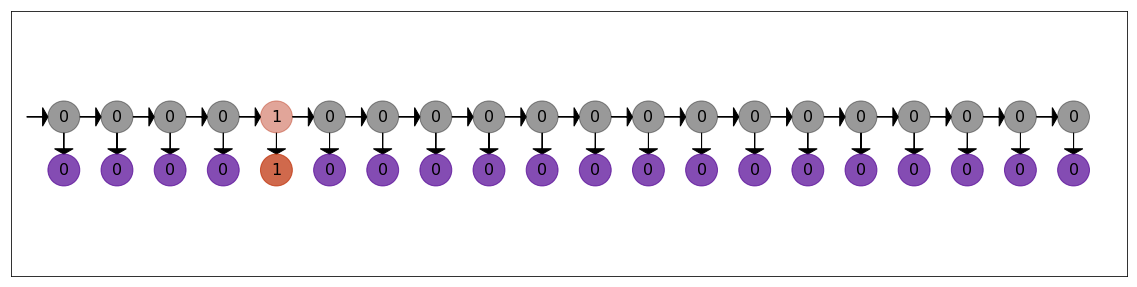

In [9]:
seq_len = 20
s_seq, e_seq = hmm.generate( seq_len )

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq )

### Find Most Likely State Sequence
If we have the model parameters and emission sequence, we can find the most probable state sequence that would generate it. Notice, that it can be different, than the actual sequence that has generated the emissions.  
We will use Viterbi algorithm for the calculation.


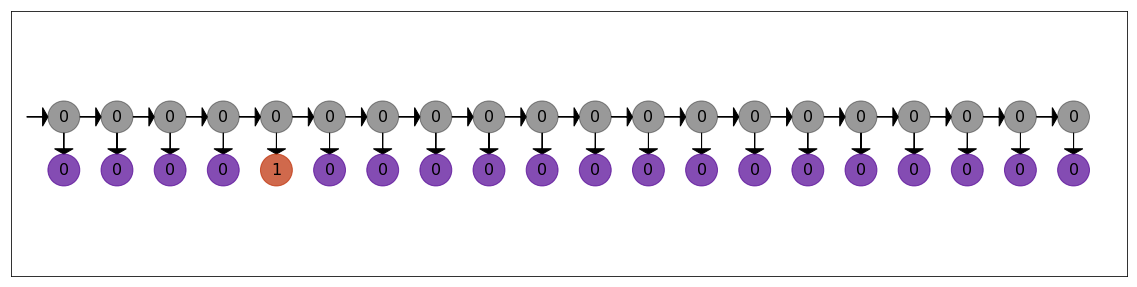

In [10]:
( prob, s_seq ) =  hmm.viterbi( e_seq )
# Let's print the most likely state sequence, it can be same or differ from the sequence above.
hmms.plot_hmm( s_seq, e_seq )

The *prob* parameter store the probability of the sequence.  
All the probabilities in the library are stored in the logarithm of their actual value. As the number of possible sequences grows exponentialy by it length, it could easily lead to float underflow.  
You can easily transform it to the normal scale value applying *exp* function. 

In [11]:
np.exp( prob )

0.0011678722324096585

### The Probability of the Emission Sequence
We can compute the probabilityoft the model generating the emission sequence.

In [12]:
np.exp( hmm.emission_estimate( e_seq ) )

0.0021549292355307007

### Create Hidden Markov Model with Random Parameters
We will use *get_random_parameters* function to generate parameters. It takes arguments for number of hidden states and number of observation variables.

In [13]:
hmm_r = hmms.DtHMM.random( 2,3 )
# We can print all the parameters.
hmms.print_parameters( hmm_r )

Initial probabilities (π) :


,0
0,0.374266
1,0.625734


Transition probabilities matrix (A):


,0,1
0,0.601415,0.398585
1,0.679710,0.320290


Emission probabilities matrix (B):


,0,1,2
0,0.192283,0.279091,0.528626
1,0.305775,0.633709,0.060516


### Parameters Estimation - Baum Welch Algorithm
We usually do not know the real parameters of the model.  
Here we will have several output variables (emissions) sequences and we will show, how to estimate the model parameters

Let's start by creating some artifficial data. We will use the previously defined model for it.


In [14]:
seq_num = 1
seq_len = 200
data = np.empty( (seq_num, seq_len), dtype=int )

for i in range(seq_num):
    _, data[i] = hmm.generate( seq_len )

Let's compare the dataset likelihood estimation of model used for generating the data and the random parameters model. 

In [15]:
print( "Generator model:" , np.exp( hmm.data_estimate(data)   ) )
print( "Random model:   " ,np.exp( hmm_r.data_estimate(data) ) )

Generator model: 1.54755225221e-48
Random model:    8.3611792431e-121


Most likely the probability that the data was generated by random model is extremly low.

Now we can take the random model and reestimate it to fit the data better.

In [16]:
hmm_r.baum_welch( data, 10 )
print( "Reestimated model after 10 iterations:   " ,np.exp( hmm_r.data_estimate(data) ) )
#TODO prove that the warning doesn't matter

Reestimated model after 10 iterations:    2.48089384998e-45


The probability of the reestimated model should now be similiar (possibly even better) that the generator's model. If it is not, you can try to run the estimation procedure more time at different randomly generated models. It could happen that the estimation fall in the local optima.

If you are satisfied with the results, you can run some more iteration to fine-tune it.

In [17]:
hmm_r.baum_welch( data, 1 )
print( "Reestimated model after 110 iterations:   " ,np.exp( hmm_r.data_estimate(data) ) )

Reestimated model after 110 iterations:    2.49962695222e-45


In [18]:
hmm.baum_welch( data, 10 )  
print( "Gnerator model after 10 iterations:   " ,np.exp( hmm_r.data_estimate(data) ) )

Gnerator model after 10 iterations:    2.49962695222e-45


In [19]:
hmms.print_parameters( hmm_r )
hmms.print_parameters( hmm )

Initial probabilities (π) :


,0
0,0.127802
1,0.872198


Transition probabilities matrix (A):


,0,1
0,0.491662,0.508338
1,0.625841,0.374159


Emission probabilities matrix (B):


,0,1,2
0,0.813013,0.056294,0.130693
1,0.906353,0.086764,0.006883


Initial probabilities (π) :


,0
0,0.999981
1,0.000019


Transition probabilities matrix (A):


,0,1
0,0.932787,0.067213
1,0.501495,0.498505


Emission probabilities matrix (B):


,0,1,2
0,0.909402,0.032557,0.058041
1,0.442874,0.353652,0.203474


[  2.73764376e-93   2.14206075e-45   2.14456263e-45   2.14724763e-45
   2.15011643e-45   2.15318618e-45   2.15647419e-45   2.16001440e-45
   2.16380804e-45   2.16788950e-45   2.17224380e-45   2.17690578e-45
   2.18191068e-45   2.18724411e-45   2.19292518e-45   2.19897328e-45
   2.20539138e-45   2.21219949e-45   2.21940111e-45   2.22699993e-45
   2.23498282e-45   2.24335373e-45   2.25213397e-45   2.26127634e-45
   2.27080229e-45   2.28068156e-45   2.29091839e-45   2.30146454e-45
   2.31232385e-45   2.32346483e-45   2.33485543e-45   2.34648088e-45
   2.35832615e-45   2.37033972e-45   2.38252355e-45   2.39482481e-45
   2.40724469e-45   2.41974744e-45   2.43231512e-45   2.44492943e-45
   2.45755290e-45   2.47020386e-45   2.48286311e-45   2.49549205e-45
   2.50812781e-45   2.52075062e-45   2.53334032e-45   2.54591521e-45
   2.55849395e-45   2.57107599e-45   2.58366077e-45]


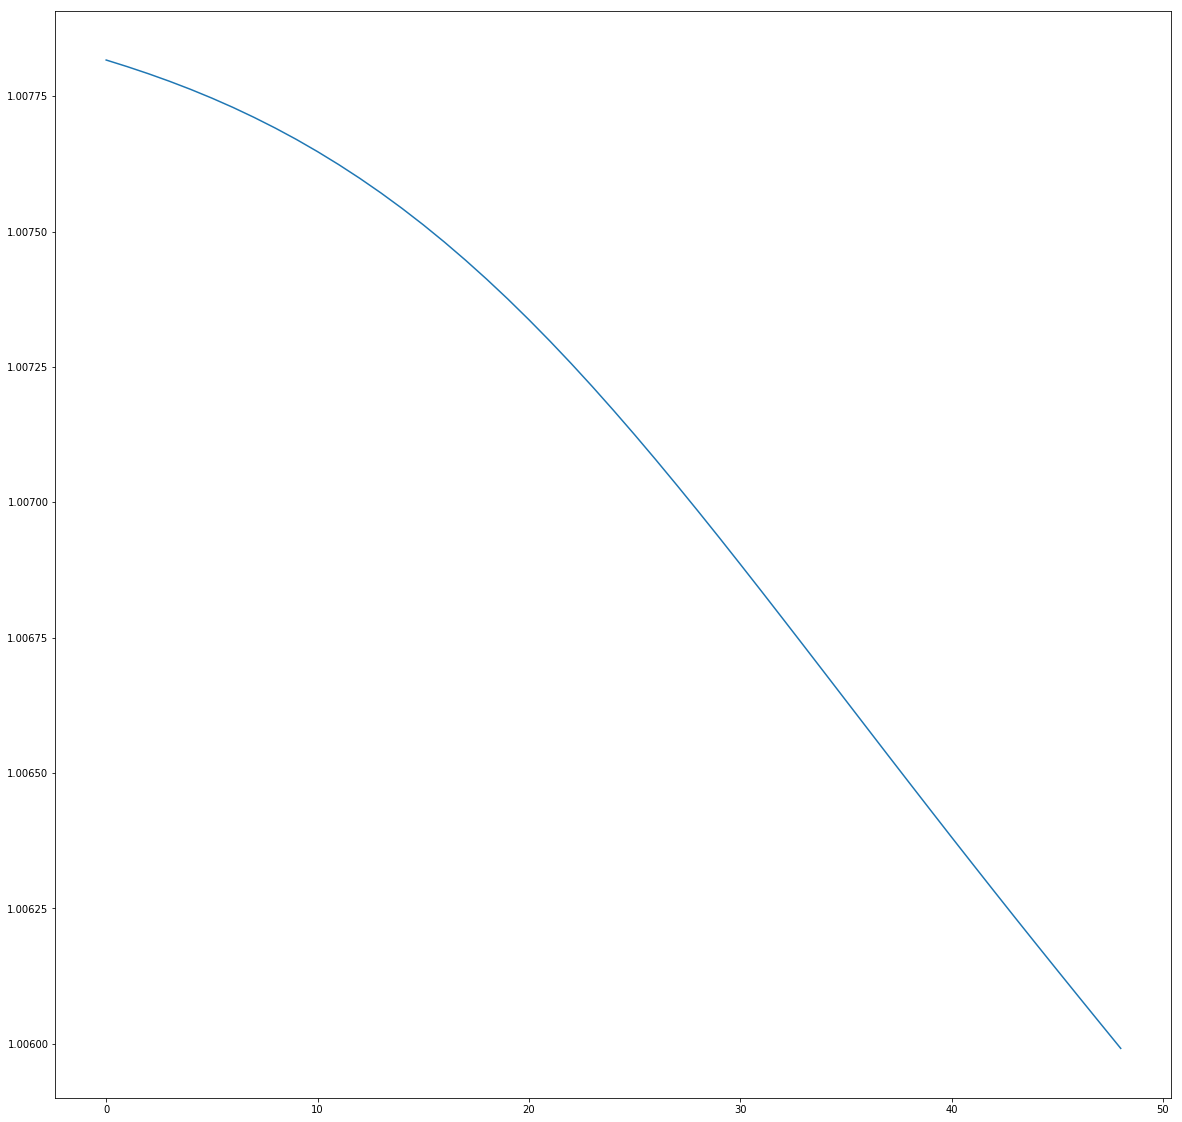

In [20]:
hmm_r = hmms.DtHMM.random(2,3) 
real = hmm.data_estimate(data)
out = hmm_r.baum_welch_graph( data, 50 )
print( np.exp(out) )
plt.plot( out[2:] / real  )
plt.show()

In [21]:
hmm.save_params("Models/my_file")
hmf = hmms.DtHMM.from_file("Models/my_file.npz")

In [22]:
hmms.print_parameters( hmf )
hmms.print_parameters( hmm )

Initial probabilities (π) :


,0
0,0.999981
1,0.000019


Transition probabilities matrix (A):


,0,1
0,0.932787,0.067213
1,0.501495,0.498505


Emission probabilities matrix (B):


,0,1,2
0,0.909402,0.032557,0.058041
1,0.442874,0.353652,0.203474


Initial probabilities (π) :


,0
0,0.999981
1,0.000019


Transition probabilities matrix (A):


,0,1
0,0.932787,0.067213
1,0.501495,0.498505


Emission probabilities matrix (B):


,0,1,2
0,0.909402,0.032557,0.058041
1,0.442874,0.353652,0.203474


In [23]:
import numpy
import scipy.linalg

def get_dthmm_params( cthmm ):
    """given the cthmm get parameters for dthmm"""
    A = scipy.linalg.expm( cthmm.q )  #the transition rate is set as the one time unit probabilities of continuos model
    B = cthmm.b
    Pi = cthmm.pi
    return (A,B,Pi)


def create_data( dthmm, size ):
    """Create output variables and time sequences generated by dthmm
       size = ( number of sequences, length of sequences  )
    """

    e = numpy.empty( size, dtype=int )
    t = numpy.empty( size, dtype=int )

    for i in range( size[0] ):
        e[i] = dthmm.generate( size[1] )[1]
        t[i] = numpy.arange(  size[1] )

    return (t,e)

In [24]:
Q = numpy.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
B = numpy.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
Pi = numpy.array( [0.6,0,0.4] )

In [25]:
cthmm = hmms.CtHMM( Q,B,Pi )
dthmm = hmms.DtHMM( *get_dthmm_params(cthmm) )

In [26]:
t, e = create_data( dthmm, (50,50) )

ct = hmms.CtHMM.random(3,3)
dt = hmms.DtHMM( *get_dthmm_params(ct) )
    
#hmms.print_parameters( dt )
#hmms.print_parameters( ct )

creal = cthmm.data_estimate(t,e)
dreal = dthmm.data_estimate(e)
print(creal)
print(dreal)

int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.25 ]
 [ 0.25  -0.5    0.25 ]
 [ 0.25   0.125 -0.375]]
int 1
Q [[-0.375  0.125  0.2

int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.        ]]
int 1
Q [[-1.          0.93903665  0.06096335]
 [ 0.24353457 -1.          0.75646543]
 [ 0.61343684  0.38656316 -1.   

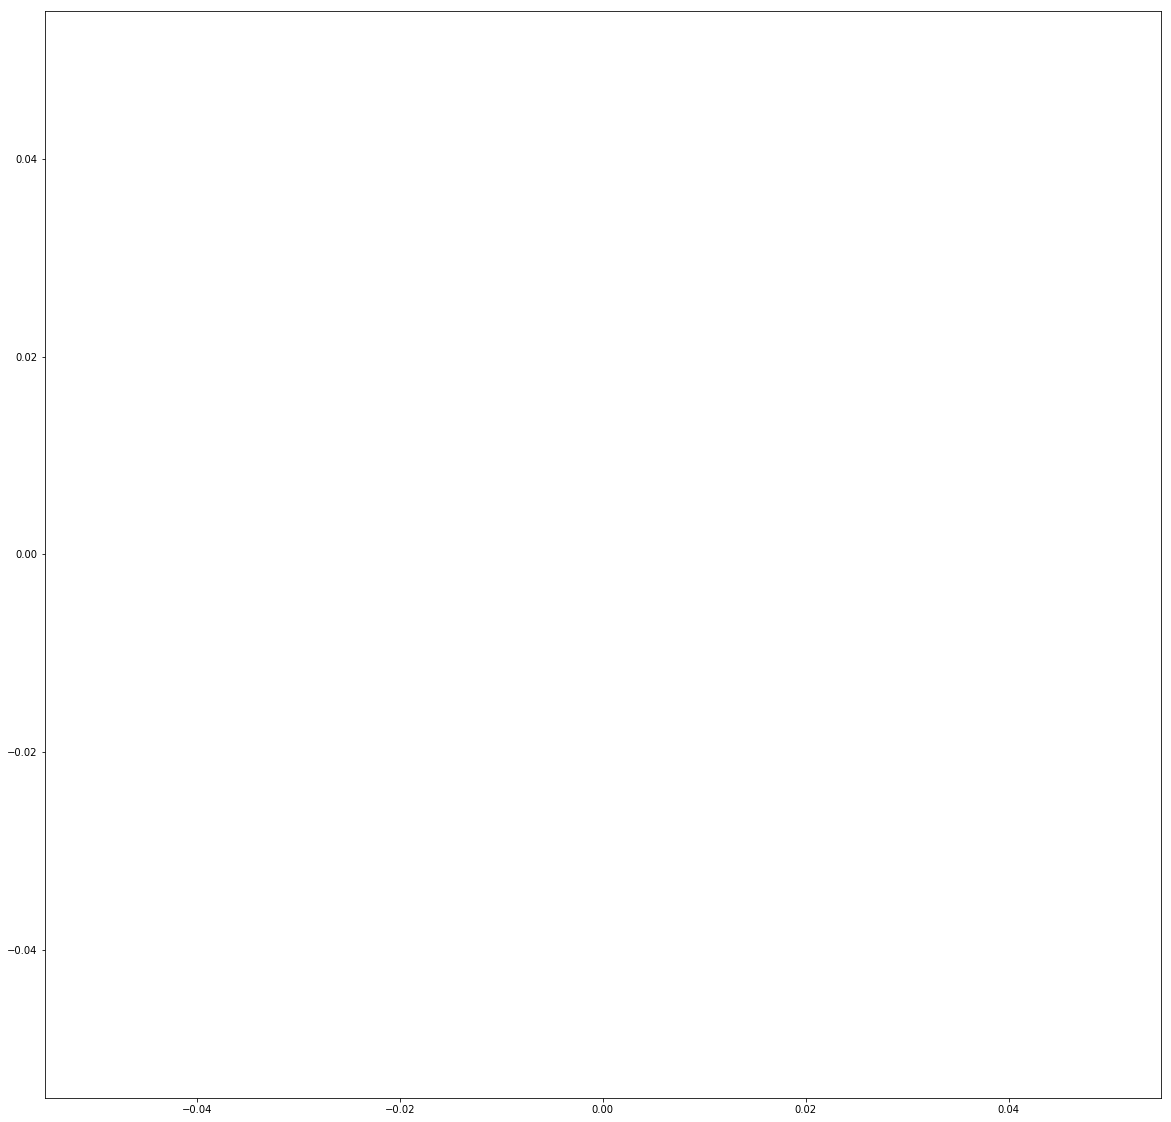

In [27]:

out = dt.baum_welch_graph( e, 1 )
plt.plot( out[2:] / dreal  )

outc = ct.baum_welch_graph( t,e, 1 )
plt.plot( outc[2:] / dreal  )

plt.show()


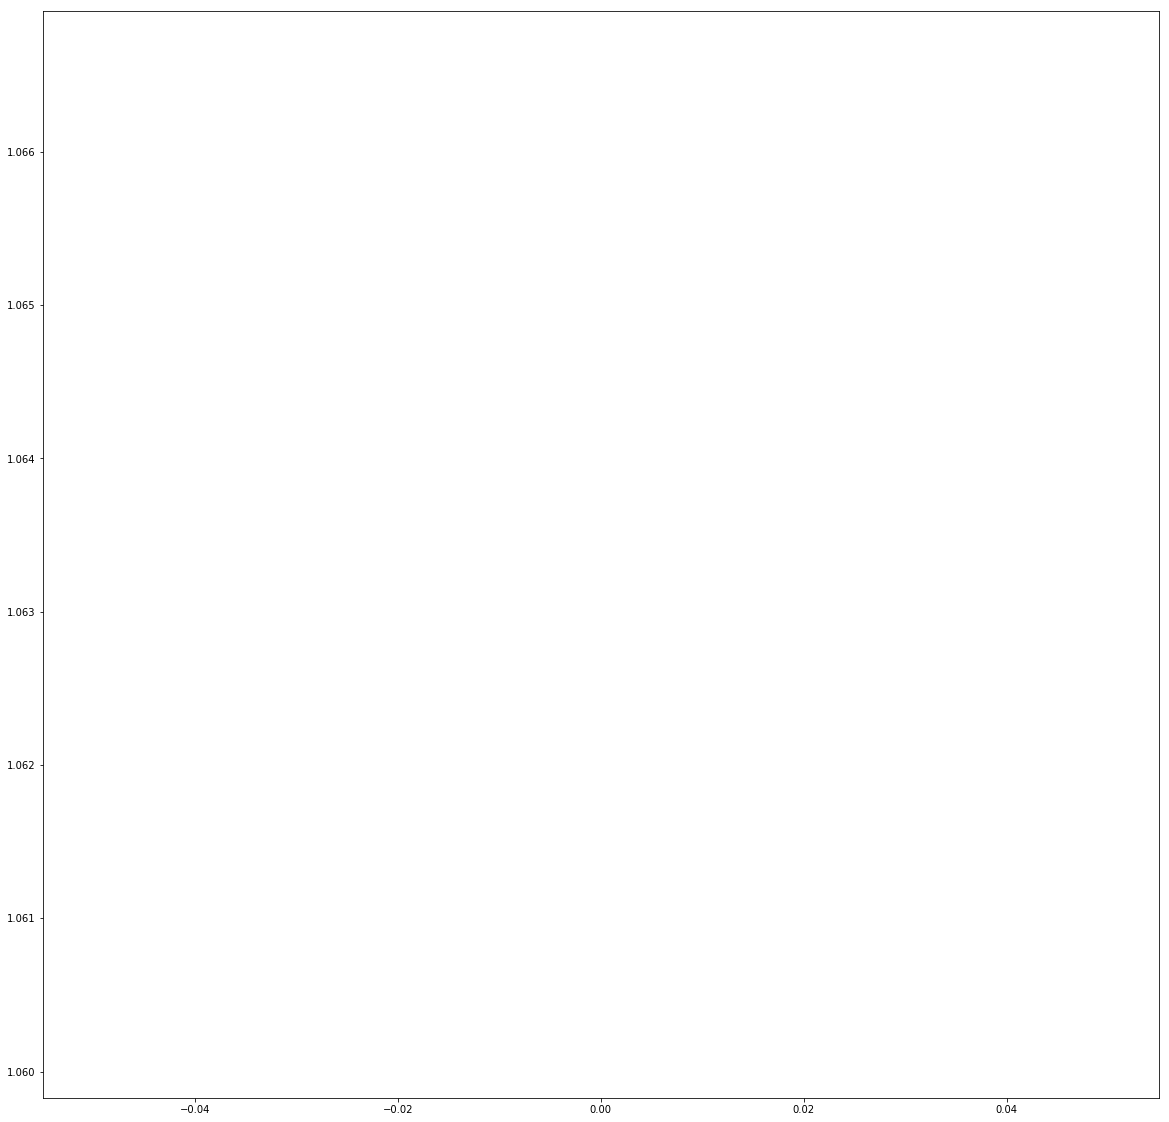

In [28]:

plt.plot( out[1:] / dreal  )
plt.plot( outc[1:] / dreal  )
#plt.savefig('100itchmmvsdtmm3.svg')
plt.show()


In [29]:
cest = ct.data_estimate(t,e)
dest = dt.data_estimate(e)
print(cest)
print(dest)

int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.8974605 ]]
int 1
Q [[-1.14350444  1.07437148  0.06913297]
 [ 0.19807094 -0.93522904  0.7371581 ]
 [ 0.4993732   0.3980873  -0.897